In [114]:
import numpy as np
import matplotlib.pyplot as plt

In [129]:
class simple_iterates:
    x = 0
    h = 0.1
    B = 0.5
    
    def __iter__(self):
        return self
    
    def __next__(self):
        self.x = (1-self.h*self.B)*self.x + np.random.normal(0, 0)
        return self.x

In [130]:
def initialize_params(n):
    mu_positions = np.random.uniform(-1, 1, n)
    A_positions = np.random.uniform(0, 1, n)
    Sigma_positions = np.random.uniform(0, 0.5, n)
    positions = np.stack((mu_positions, A_positions, Sigma_positions))
    
    weights = np.full(n, 1/n)
    
    return dict(positions=positions, weights=weights)


def initialize_A(n):
    mu_positions = np.random.uniform(0, 1, n)
    mu_weights = np.full((1, n), 1/n)
    return np.concatenate((mu_positions, mu_weights))

def gaussian_kernel(params, x_prev, x_curr):
    #params = [mu, A, Sigma]
    mu = params[0]
    A = params[1]
    Sigma = params[2]
    return np.exp(-((x_curr - (mu + A*(x_prev-mu)))**2)/(2*Sigma))
    
def reweight(particles, iterates):
    positions = particles["positions"]
    weights = particles["weights"]
    
    def iterates_prob(position):
        prob = 1
        for i in range(0, iterates.size-1):
            prob = prob * gaussian_kernel(position, iterates[i], iterates[i+1])
        return prob
    
    probs = np.zeros(weights.size)
    for idx, position in enumerate(positions.T):
        probs[idx] = iterates_prob(position)
    
    weights = np.multiply(weights, probs)
    weights = weights/np.sum(weights)
    
    return dict(positions=positions, weights=weights)

def resample(particles):
    positions = particles["positions"]
    weights = particles["weights"]
    
    positions = positions[:, np.random.choice(positions.shape[1], positions.shape[1], p=weights)]
    weights = np.full(weights.size, 1/weights.size)
    return dict(positions=positions, weights=weights)

def Optimize(num_particles, batch_size, num_iterations):
    
    iterates = simple_iterates()
    iterates_array = np.zeros(num_iterations*batch_size);
    
    particles_arr = []
    particles_arr.append(initialize_params(num_particles))
    
    for i in range(0, num_iterations):
        if (i==0):
            last_iterate = next(iterates)
        else:
            last_iterate = iterates_array[i*batch_size - 1]
        
        iterates_batch = np.zeros(batch_size)
        for p in range(0, batch_size):        
            iterates_batch[p] = next(iterates)
        
        new_particles = particles_arr[-1]
        
        #STEP 1: Reweighting
        new_particles = reweight(new_particles, np.insert(iterates_batch, 0, last_iterate, axis=0))
        
        
        #STEP 2: Resampling
        new_particles = resample(new_particles)
        
        particles_arr.append(new_particles)
        
        iterates_array[i*batch_size:(i+1)*batch_size] = iterates_batch
        
    print(iterates_array)
        
    return particles_arr

In [141]:
c = Optimize(10000, 5, 200)
print(c[-1])
print(np.mean(c[-1]["positions"][0]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

(array([  82.,    0.,    0.,  161.,  473., 1365.,  339.,  347.,   38.,
         195.]),
 array([-0.68715863, -0.55753633, -0.42791403, -0.29829174, -0.16866944,
        -0.03904714,  0.09057516,  0.22019746,  0.34981975,  0.47944205,
         0.60906435]),
 <a list of 10 Patch objects>)

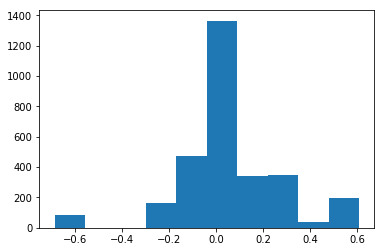

In [140]:
plt.hist(c[-1]["positions"][0])